# Statistical learning

The difference between statistical learning and classical machine learning is in the way they handle data. Rather than working with the data directly, statistical learning works with models of this data (statistical models, formulated in terms of distributions). There is a slight difference in ultimate goals too: while ML is striving towards narrower quantifiable goals, such as regression/classification error, the main obsession in the statistical learning circles is model inference. This creates a cultural rift as well, while ML researchers are publishing their work in conferences and are more industry focused, the statistical learning reseachers tend to publish in scientific journals and have a more academic focus.

Further read:
- http://brenocon.com/blog/2008/12/statistics-vs-machine-learning-fight/
- https://statmodeling.stat.columbia.edu/2008/12/03/machine_learnin/


## Frequentism vs Bayesian probability estimation

- Probabilities are fundamentally related to frequencies of events.
- Probabilities are fundamentally related to our own knowledge about an event.
> There is no 'true' probability because the probability of an event is fixed. Or?

Let us make a Bayesian probabilistic model for gene expression. The number of reads mapping to a gene can be assumed to be Poisson approximated. Let's say we have a set of technical replicates giving various coverage numbers for a certain gene. Let $E = \{E_i,e_i\}$ be the set of coverage numbers and associated errors drawing from the technical replicates. The question is to find a best estimate of the true expression $E_{true}$.

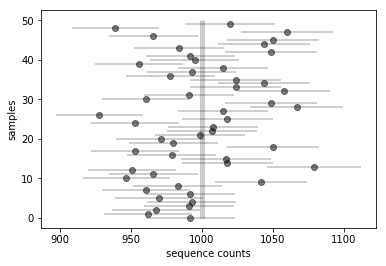

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

np.random.seed(1)  # for repeatability

E_true = 1000  # true expression
N = 50 # samples
E = stats.poisson(E_true).rvs(N)  # N measurements of the expression
err = np.sqrt(E)  # errors on Poisson counts estimated via square root

fig, ax = plt.subplots()
ax.errorbar(E, np.arange(N), xerr=err, fmt='ok', ecolor='gray', alpha=0.5)
ax.vlines([E_true], 0, N, linewidth=5, alpha=0.2)
ax.set_xlabel("sequence counts");ax.set_ylabel("samples");

Now given our errors of estimation, what is our best expectation for the true expression?

The frequentist approach is based on a [maximum likelihood estimate](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation). Basically one can compute the probability of an observation given that the true gene expression value is fixed, and then compute the product of these probabilities for each data point:

$$ L(E|E_{true}) = \prod_{i=1}^{N}{ P (E_i|E_{true}) } $$

What we want is to compute the E_true for which the log likelihood estimate is maximized, and in this case it can be solved analytically to this formula (while generally alternatively approximated via optimization, although it is not always possible):

$$ E_{est} = argmax_{E_{true}} = argmin_{E_{true}} {- \sum_{i=1}^{N}log(P(E_i|E_{true})) } \approx \frac{\sum{w_i E_i}}{\sum{w_i}}, w_i = 1/e_i^2 $$

(Also, in this case) we can also estimate the error of measurement by using a gaussian estimate of the likelihood function at its maximum:

In [6]:
w = 1. / err ** 2
print("""
      E_true = {0}
      E_est  = {1:.0f} +/- {2:.0f} (based on {3} measurements)
      """.format(E_true, (w * E).sum() / w.sum(), w.sum() ** -0.5, N))


      E_true = 1000
      E_est  = 998 +/- 4 (based on 50 measurements)
      


When using the Bayesian approach, we are estimating the probability of the model parameters giving the data, so no absolute estimate. This is also called posterior probability. We do this using the likelihood and the model prior, which is an expectation of the model before we are given the data. The data probability is encoding how likely our data is, and is usually approximated into a normalization term. The formula used is also known as [Bayes theorem](https://en.wikipedia.org/wiki/Bayes_theorem) but is using a [Bayesian interpretation of probability](https://en.wikipedia.org/wiki/Bayesian_probability). 

$$ P(E_{true}|E) = \frac{P(E|E_{true})P(E_{true})}{P(E)}$$

$$ {posterior} = \frac{{likelihood}~\cdot~{prior}}{data~probability}$$

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mu]
Sampling 4 chains: 100%|██████████| 62000/62000 [00:05<00:00, 11614.66draws/s]
The number of effective samples is smaller than 25% for some parameters.


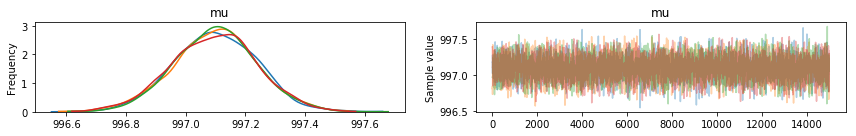

In [18]:
import pymc3 as pm

with pm.Model():
    mu = pm.Normal('mu', 900, 1.)
    sigma = 1.
    
    E_obs = pm.Normal('E_obs', mu=mu, sd=sigma, observed=E)
    
    step = pm.Metropolis()
    trace = pm.sample(15000, step)
    
#sns.distplot(trace[2000:]['mu'], label='PyMC3 sampler');
#sns.distplot(posterior[500:], label='Hand-written sampler');
pm.traceplot(trace)
plt.show()


Task:
- How did we know to start with 900 as the expected mean? Try putting 0, then 2000 and come up with a general strategy!
- Use a bayesian parametrization for sigma as well. What do you observe?
- Try another sampler.

logp = 433.91, ||grad|| = 2.3836e+08: 100%|██████████| 101/101 [00:00<00:00, 3442.48it/s]     
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:10<00:00, 7669.75draws/s] 


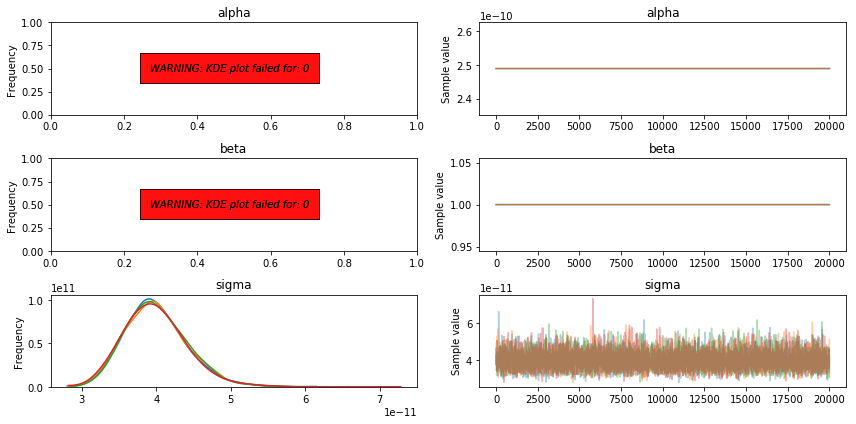

In [8]:
def log_prior(E_true):
    return 1  # flat prior

def log_likelihood(E_true, E, e):
    return -0.5 * np.sum(np.log(2 * np.pi * e ** 2)
                         + (E - E_true) ** 2 / e ** 2)

def log_posterior(E_true, E, e):
    return log_prior(E_true) + log_likelihood(E_true, E, e)

import pymc3 as pm
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.HalfNormal('sigma', sd=1)

    # Expected value of outcome
    mu = alpha + beta*E

    # Likelihood (sampling distribution) of observations
    E_obs = pm.Normal('Y_obs', mu = mu, sd = sigma, observed = E)
    
    
    start = pm.find_MAP(model=basic_model)
    step = pm.Metropolis()

    # draw 20000 posterior samples
    trace = pm.sample(20000, step=step, start=start)

_ = pm.traceplot(trace)
plt.show()

In [3]:
import pymc3 as pm
help(pm.Normal)

Help on class Normal in module pymc3.distributions.continuous:

class Normal(pymc3.distributions.distribution.Continuous)
 |  Univariate normal log-likelihood.
 |  
 |  The pdf of this distribution is
 |  
 |  .. math::
 |  
 |     f(x \mid \mu, \tau) =
 |         \sqrt{\frac{\tau}{2\pi}}
 |         \exp\left\{ -\frac{\tau}{2} (x-\mu)^2 \right\}
 |  
 |  Normal distribution can be parameterized either in terms of precision
 |  or standard deviation. The link between the two parametrizations is
 |  given by
 |  
 |  .. math::
 |  
 |     \tau = \dfrac{1}{\sigma^2}
 |  
 |  .. plot::
 |  
 |      import matplotlib.pyplot as plt
 |      import numpy as np
 |      import scipy.stats as st
 |      plt.style.use('seaborn-darkgrid')
 |      x = np.linspace(-5, 5, 1000)
 |      mus = [0., 0., 0., -2.]
 |      sds = [0.4, 1., 2., 0.4]
 |      for mu, sd in zip(mus, sds):
 |          pdf = st.norm.pdf(x, mu, sd)
 |          plt.plot(x, pdf, label=r'$\mu$ = {}, $\sigma$ = {}'.format(mu, sd))
 |  

# TODO
- probabilistic programming: 
https://docs.pymc.io/notebooks/bayesian_neural_network_with_sgfs.html
- variational inference: 
https://docs.pymc.io/notebooks/bayesian_neural_network_advi.html
